In [1]:
!pip install opencv-python ultralytics matplotlib pyyaml


[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import os
import zipfile
import glob
import cv2
import random
import shutil
import json
import yaml
import ultralytics
import matplotlib.pyplot as plt
from torchvision import transforms
from ultralytics import YOLO
from ultralytics.utils.plotting import Annotator

In [3]:
zip_path = "fittogether.zip"
extract_path = "fittogether"

os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("압축 해제 완료!")

압축 해제 완료!


In [4]:
json_dir = "fittogether"      # JSON 있는 폴더
label_out_dir = "labels"      # YOLO 라벨 저장 폴더

os.makedirs(label_out_dir, exist_ok=True)

class_map = {
    "players": 0,
    "ball": 1,
    "others": 2
}

for file in os.listdir(json_dir):
    if not file.endswith(".json"):
        continue

    json_path = os.path.join(json_dir, file)
    
    with open(json_path, "r", encoding="utf-8") as f:
        data = json.load(f)

    img_w = data["imageWidth"]
    img_h = data["imageHeight"]

    label_lines = []

    for shape in data["shapes"]:
        label = shape["label"]
        if label not in class_map:
            continue

        points = shape["points"]

        xs = [p[0] for p in points]
        ys = [p[1] for p in points]
        
        x1, x2 = min(xs), max(xs)
        y1, y2 = min(ys), max(ys)
        
        # YOLO 변환
        cx = ((x1 + x2) / 2) / img_w
        cy = ((y1 + y2) / 2) / img_h
        w  = abs(x2 - x1) / img_w
        h  = abs(y2 - y1) / img_h

        class_id = class_map[label]
        label_lines.append(f"{class_id} {cx:.6f} {cy:.6f} {w:.6f} {h:.6f}")

    # txt 파일로 저장
    txt_name = file.replace(".json", ".txt")
    txt_path = os.path.join(label_out_dir, txt_name)

    with open(txt_path, "w") as f:
        f.write("\n".join(label_lines))

print("JSON → YOLO 라벨 변환 완료")

JSON → YOLO 라벨 변환 완료


In [5]:
with open("labels/video_01_000036.txt") as f:
    print(f.read())

0 0.669852 0.781112 0.011478 0.060647
0 0.549771 0.530676 0.009391 0.044665
0 0.534319 0.477807 0.011238 0.046234
0 0.495028 0.478449 0.015652 0.044665
0 0.567911 0.431715 0.007144 0.042239
0 0.614467 0.418301 0.013244 0.038529
0 0.696768 0.498958 0.010925 0.041640
0 0.715558 0.470292 0.011624 0.038688
0 0.695369 0.482877 0.013722 0.043350
0 0.697773 0.462134 0.009439 0.040708
0 0.771930 0.471923 0.011449 0.043505
1 0.847654 0.493643 0.004557 0.007644
2 0.891637 0.432189 0.009459 0.042804
0 0.895464 0.428979 0.009029 0.037912
0 0.950669 0.402838 0.011093 0.035772
0 0.992589 0.453897 0.008083 0.041887
2 0.622669 0.318959 0.005502 0.028450


In [6]:
base_dir = "dataset"

paths = [
    f"{base_dir}/images/train",
    f"{base_dir}/images/val",
    f"{base_dir}/labels/train",
    f"{base_dir}/labels/val",
]

for p in paths:
    os.makedirs(p, exist_ok=True)

print("폴더 구조 생성")

폴더 구조 생성


In [7]:
image_dir = "fittogether"
label_dir = "labels"

images = [f for f in os.listdir(image_dir) if f.endswith(".jpg")]
random.shuffle(images)

split_ratio = 0.8
split_idx = int(len(images) * split_ratio)

train_imgs = images[:split_idx]
val_imgs   = images[split_idx:]

def move_files(img_list, img_dst, lbl_dst):
    for img in img_list:
        shutil.copy(
            os.path.join(image_dir, img),
            os.path.join(img_dst, img)
        )

        label_name = img.replace(".jpg", ".txt")
        shutil.copy(
            os.path.join(label_dir, label_name),
            os.path.join(lbl_dst, label_name)
        )

move_files(train_imgs, f"{base_dir}/images/train", f"{base_dir}/labels/train")
move_files(val_imgs,   f"{base_dir}/images/val",   f"{base_dir}/labels/val")

print(f"train: {len(train_imgs)}장 / val: {len(val_imgs)}장")

train: 8920장 / val: 2230장


In [8]:
data_yaml = {
    "names": {
        0: "players",
        1: "ball",
        2: "others"
    },
    "path": "dataset",
    "train": "images/train",
    "val": "images/val",
}

with open("dataset/data.yaml", "w") as f:
    yaml.dump(data_yaml, f, sort_keys=False)

print("data.yaml 생성")

data.yaml 생성


In [9]:
model = YOLO("yolov8n.pt")
model.train(
    data="dataset/data.yaml", 
    epochs=30, 
    imgsz=640, 
    batch=8,
    device=0,
    workers=2,
    amp=True,
    patience=10,
    name="model_defalut",
)

Ultralytics 8.3.252  Python-3.12.10 torch-2.6.0.dev20241112+cu121 CUDA:0 (NVIDIA GeForce RTX 3070, 8191MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=dataset/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=model_defalut, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x0000016A1BE136B0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          

In [13]:
model_change_imgsize = YOLO("yolov8n.pt")

model_change_imgsize.train(
    data="dataset/data.yaml",
    epochs=30,
    imgsz=960, # 이미지 크기 640 -> 960으로 조정
    batch=8,
    device=0,
    workers=2,
    amp=True,
    patience=10,
    name="model_imgsize_960"
)

Ultralytics 8.3.252  Python-3.12.10 torch-2.6.0.dev20241112+cu121 CUDA:0 (NVIDIA GeForce RTX 3070, 8191MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=dataset/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=960, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=model_imgsize_960, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=10, perspective=0.

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x000001691B8C0D60>
Traceback (most recent call last):
  File "C:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "C:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py", line 1562, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
                                   ^^^^^^^^^^^^^^^^^^^^
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'


       1/30      3.96G      1.376      1.058     0.8436        241        960: 100% ━━━━━━━━━━━━ 1335/1335 4.3it/s 5:11<0.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 250/250 6.1it/s 41.1s<0.2s
                   all       3989      72353      0.952      0.615      0.674      0.406

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       2/30      3.96G      1.239      0.623     0.8241        197        960: 100% ━━━━━━━━━━━━ 1335/1335 4.4it/s 5:06<0.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 250/250 5.3it/s 46.9s<0.2s
                   all       3989      72353      0.832      0.662       0.68      0.423

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       3/30      3.97G      1.206      0.571     0.8197        133        960: 100% ━━━━━━━━━━━━ 1335/1335 4.5it/s 4:58<0.2s
                 Cl

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x00000169685CDDC0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          

In [9]:
model = YOLO('runs/detect/model_defalut/weights/best.pt')
metrics_n = model.val(split='val')
map50_n = metrics_n.box.map50
map_n = metrics_n.box.map

model_change_imgsize = YOLO('runs/detect/model_imgsize_960/weights/best.pt')
metrics_i = model_change_imgsize.val(split='val')
map50_i = metrics_i.box.map50
map_i = metrics_i.box.map

Ultralytics 8.3.252  Python-3.12.10 torch-2.6.0.dev20241112+cu121 CUDA:0 (NVIDIA GeForce RTX 3070, 8191MiB)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 1143.5572.5 MB/s, size: 374.3 KB)
val: Scanning D:\project\ai_subject\dataset\labels\val.cache... 3989 images, 1 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 3989/3989  0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 250/250 8.7it/s 28.7s<0.1s
                   all       3989      72353       0.82      0.648      0.688      0.448
               players       3988      61889      0.955       0.95      0.984      0.687
                  ball       2204       2208      0.588     0.0634      0.113     0.0329
                others       3983       8256      0.918       0.93      0.968      0.625
Speed: 0.9ms preprocess, 1.7ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to D:\

In [17]:
print("성능 비교 결과")
print(f"imgsz=960 → mAP50: {map50_i:.4f}, mAP50-95: {map50_i:.4f}")
print(f"imgsz=640 → mAP50: {map50_n:.4f}, mAP50-95: {map50_n:.4f}")

성능 비교 결과
imgsz=960 → mAP50: 0.7676, mAP50-95: 0.7676
imgsz=640 → mAP50: 0.6879, mAP50-95: 0.6879


In [18]:
if map50_i >= map50_n:
    print("최종 선택 모델: YOLOv8n (imgsz=960)")
    best_model = map50_i
else:
    print("최종 선택 모델: YOLOv8n (imgsz=640)")
    best_model = map50_n

최종 선택 모델: YOLOv8n (imgsz=960)


In [5]:
test_root = 'dataset/test'

test_file_list = glob.glob(f"{test_root}/images/*")
random.shuffle(test_file_list)

img_path = test_file_list[2]
img_bgr = cv2.imread(img_path)
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

color_dict = [
    (0, 0, 255),   # players
    (0, 255, 0),   # ball
    (255, 0, 0)    # others
]

dataset/test/images\video_23_000220.jpg
img_bgr is None? False


In [6]:
def inference_and_plot(model, img_rgb):
    results = model(img_rgb)[0]

    annotator = Annotator(img_rgb.copy())
    boxes = results.boxes

    for box in boxes:
        b = box.xyxy[0]
        cls = int(box.cls)
        annotator.box_label(
            b,
            model.names[cls],
            color=color_dict[cls]
        )

    return annotator.result()


0: 384x640 22 playerss, 1 others, 76.3ms
Speed: 1.8ms preprocess, 76.3ms inference, 12.6ms postprocess per image at shape (1, 3, 384, 640)

0: 544x960 20 playerss, 1 ball, 2 otherss, 46.1ms
Speed: 3.4ms preprocess, 46.1ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 960)


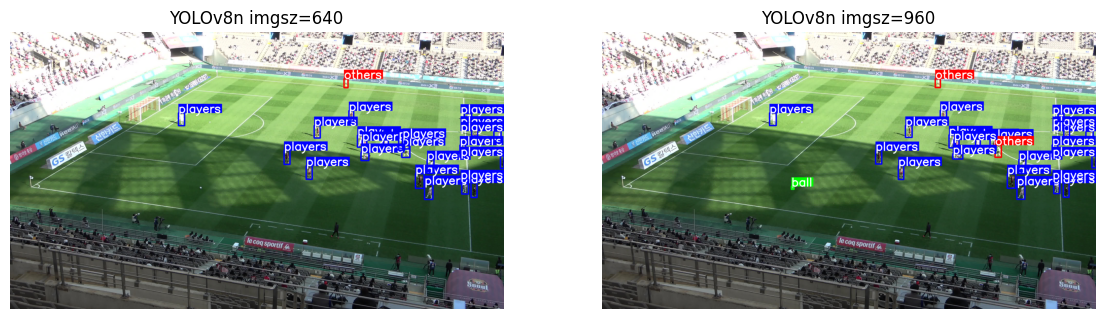

In [7]:
# 모델 불러오기
model_640 = YOLO("runs/detect/model_defalut/weights/best.pt")
model_960 = YOLO("runs/detect/model_imgsize_960/weights/best.pt")

# 추론
result_640 = inference_and_plot(model_640, img_rgb)
result_960 = inference_and_plot(model_960, img_rgb)

# 시각화
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.imshow(result_640)
plt.title("YOLOv8n imgsz=640")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(result_960)
plt.title("YOLOv8n imgsz=960")
plt.axis("off")

plt.show()
plt.close()

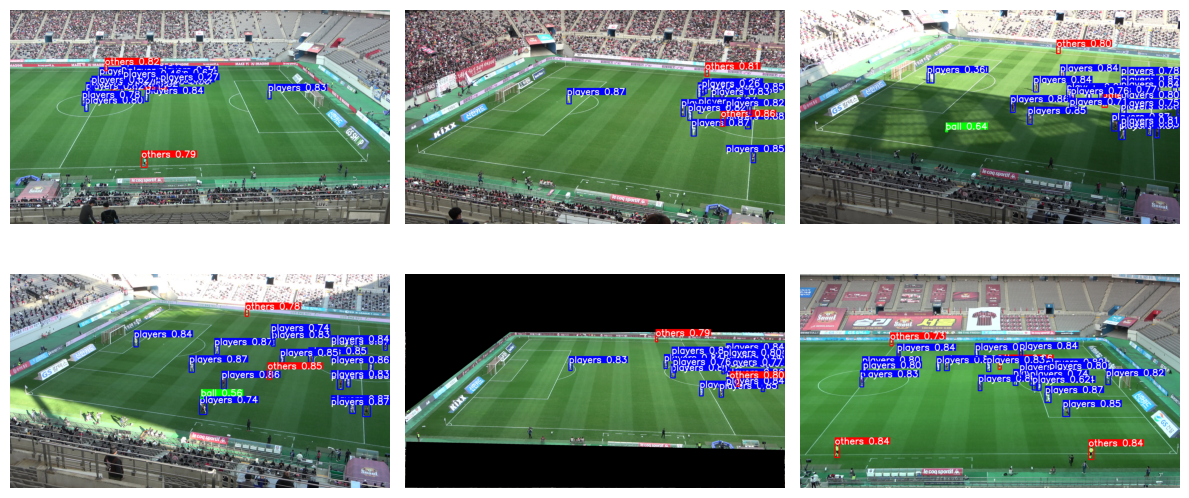

In [10]:
plt.figure(figsize=(12, 6))

for idx in range(6):
    # 1. 이미지 읽기
    test_img = cv2.imread(test_file_list[idx])
    if test_img is None:
        continue

    img_src = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

    # 2. 모델 예측
    results = model_change_imgsize(test_img, verbose=False)

    # 3. 시각화 도구 초기화
    annotator = Annotator(img_src)

    for result in results:
        boxes = result.boxes
        for box in boxes:
            b = box.xyxy[0]
            cls = int(box.cls)
            conf = float(box.conf)

            # 클래스 범위 보호
            if cls >= len(color_dict):
                continue

            label = f"{model_change_imgsize.names[cls]} {conf:.2f}"
            color = color_dict[cls]

            annotator.box_label(b, label, color)

    # 4. 결과 이미지 출력
    img_final = annotator.result()
    plt.subplot(2, 3, idx + 1)
    plt.imshow(img_final)
    plt.axis('off')

plt.tight_layout()
plt.show()